In [1]:
%env THEANO_FLAGS='device=gpu2','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, Net

env: THEANO_FLAGS='device=gpu2','floatX=float32'


Using gpu device 2: GeForce GTX 690 (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
def one_hot(y, n_classes=10):
    onehot = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')

    onehot[np.arange(y.shape[0]), y] = 1.0
    return onehot

In [7]:
y = one_hot(y)
y_test = one_hot(y_test)

In [8]:
np.prod(X.shape[1:])

784

## Going deep
but this time not exponentially

In [9]:
class DecomposedDense(layers.Layer):
    def __init__(self, incoming, num_units, k,
                 U=init.GlorotUniform(),
                 V=init.GlorotUniform(),
                 b=init.Constant(0.),
                 nonlinearity=nonlinearities.rectify,
                 **kwargs):
        super(DecomposedDense, self).__init__(incoming, **kwargs)

        num_inputs = self.input_shape[1]
        self.num_units = num_units
        self.k = k

        self.U = self.add_param(U, (num_inputs, k), name='U')
        self.V = self.add_param(V, (k, num_units), name='V')
        self.b = self.add_param(b, (num_units, ), name='b', regularizable=False)
        
        self.nonlinearity = nonlinearity

    def get_output_for(self, input, **kwargs):
        W = self.U.dot(self.V)
        activation = T.dot(input, W) + self.b

        return self.nonlinearity(activation)

    def get_output_shape_for(self, input_shape):
        return input_shape[:1] + (self.num_units,)

In [10]:
class DeepDenseMNISTNet(Net):
    def __init__(self):
        self.X_batch = T.ftensor4(name='X_batch')
        self.y_batch = T.fmatrix(name='y_batch')
        
        self.layers = []
        input_l = layers.InputLayer(shape=(None, ) + X.shape[1:], input_var=self.X_batch, name='Input')
        self.layers.append(input_l)
        
        reshape_l = layers.FlattenLayer(input_l)
        self.layers.append(reshape_l)

        for i, n_units in enumerate([100]):
            dense = DecomposedDense(
                self.layers[-1],
                num_units=n_units,
                k=20,
                nonlinearity=nonlinearities.sigmoid,
                name='Dense %d' % i
            )

            self.layers.append(dense)
        
        for i, n_units in enumerate([25], 1):
            dense = layers.DenseLayer(
                self.layers[-1],
                num_units=n_units,
                nonlinearity=nonlinearities.sigmoid,
                name='Dense %d' % i
            )

            self.layers.append(dense)
        
        output_l = layers.DenseLayer(
            self.layers[-1],
            num_units=10,
            nonlinearity=nonlinearities.softmax,
            name= 'output'
        )
        
        self.layers.append(output_l)

        self.net = output_l
        
        self.predictions = layers.get_output(self.net)
        self.pure_loss = T.mean(objectives.categorical_crossentropy(self.predictions, self.y_batch))
        
        self.regularization = reduce(
            lambda a, b: a + b, [
                T.mean(param ** 2)
                for param in layers.get_all_params(self.net, regularizable=True)
            ]
        )

        self.regularization_coef = T.fscalar('regularization_coef')
        
        self.loss = self.pure_loss + self.regularization_coef * self.regularization
        
        self.learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(self.net)

        upd = updates.adadelta(self.loss, params, learning_rate=self.learning_rate)

        self.train = theano.function(
            [self.X_batch, self.y_batch, self.regularization_coef, self.learning_rate],
            self.pure_loss,
            updates=upd
        )

        self.get_loss = theano.function([self.X_batch, self.y_batch], self.pure_loss)
        
        super(DeepDenseMNISTNet, self).__init__()
            
    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, y, n_epoches = 1, batch_size=32, regularization_coef=1.0e-3, learning_rate = 1.0):
        regularization_coef = np.float32(regularization_coef)
        learning_rate = np.float32(learning_rate)
        
        n_batches = X.shape[0] / batch_size
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        
        for epoch in xrange(n_epoches):
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                losses[epoch, i] = self.train(X[indx], y[indx], regularization_coef, learning_rate)
            
            yield losses[:(epoch + 1)]

In [11]:
deep_net = DeepDenseMNISTNet()

In [12]:
deep_net.save('deep-low-parameter-net-0.npz')

<IPython.core.display.Javascript object>


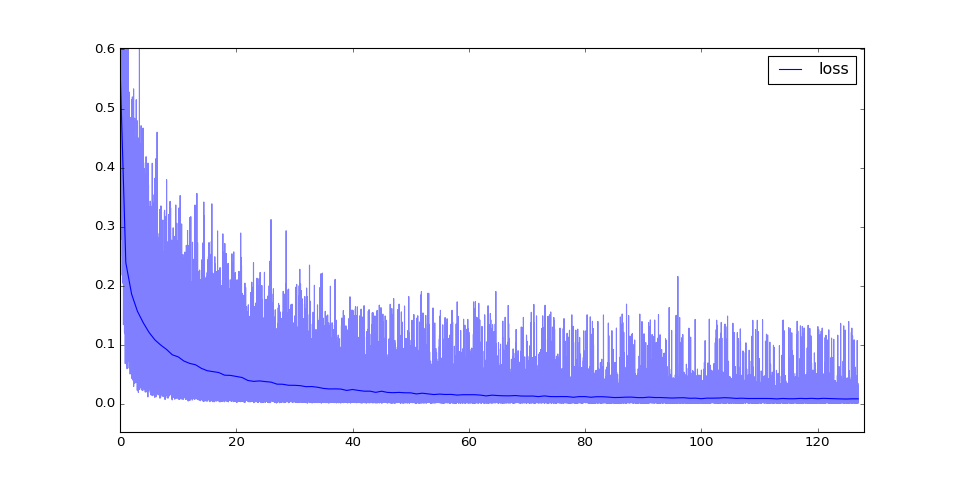

In [13]:
watcher = NNWatcher()

In [14]:
for loss in deep_net.fit(X, y, n_epoches=128, learning_rate=1.0, batch_size=64, regularization_coef=1.0e-2):
    watcher.draw(loss)

In [15]:
deep_net.save('deep-low-parameter-net-1.npz')

In [16]:
predict = theano.function([deep_net.X_batch], deep_net.predictions)

In [17]:
y_proba = predict(X_test)
print 'accuracy:', np.mean(np.argmax(y_test, axis=1) == np.argmax(y_proba, axis=1))

accuracy: 0.969


In [18]:
l = deep_net.layers[2]

In [19]:
U = l.U.get_value()
V = l.V.get_value()

<IPython.core.display.Javascript object>


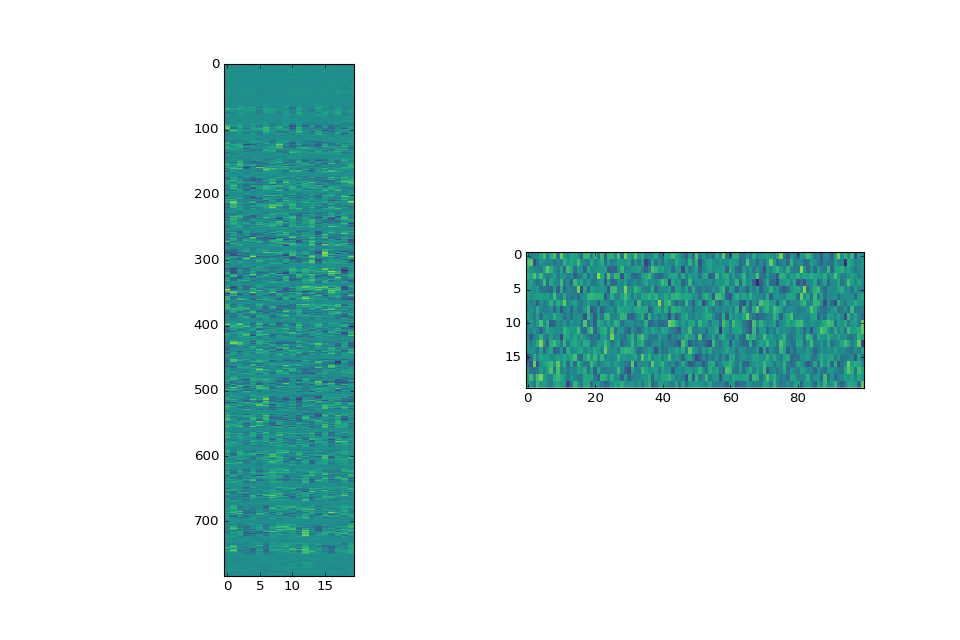

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(U, interpolation='None', aspect = 0.1, cmap=plt.cm.viridis, vmin=-2, vmax=2)
ax[1].imshow(V, interpolation='None', aspect = 2, cmap=plt.cm.viridis, vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


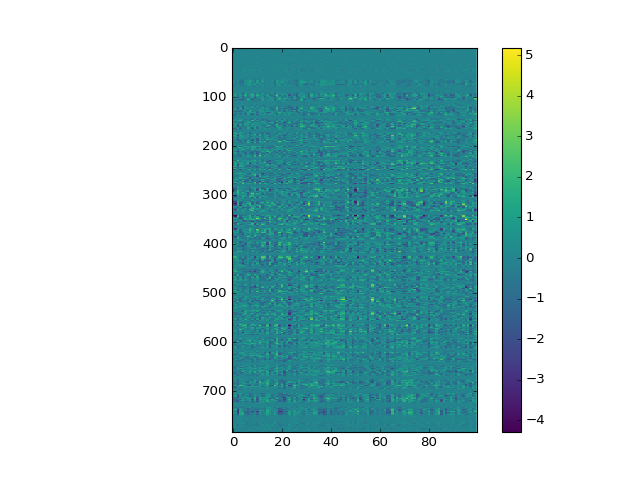

In [21]:
plt.figure()
plt.imshow(U.dot(V), interpolation='None', aspect=0.2, cmap=plt.cm.viridis)
plt.colorbar()

<IPython.core.display.Javascript object>


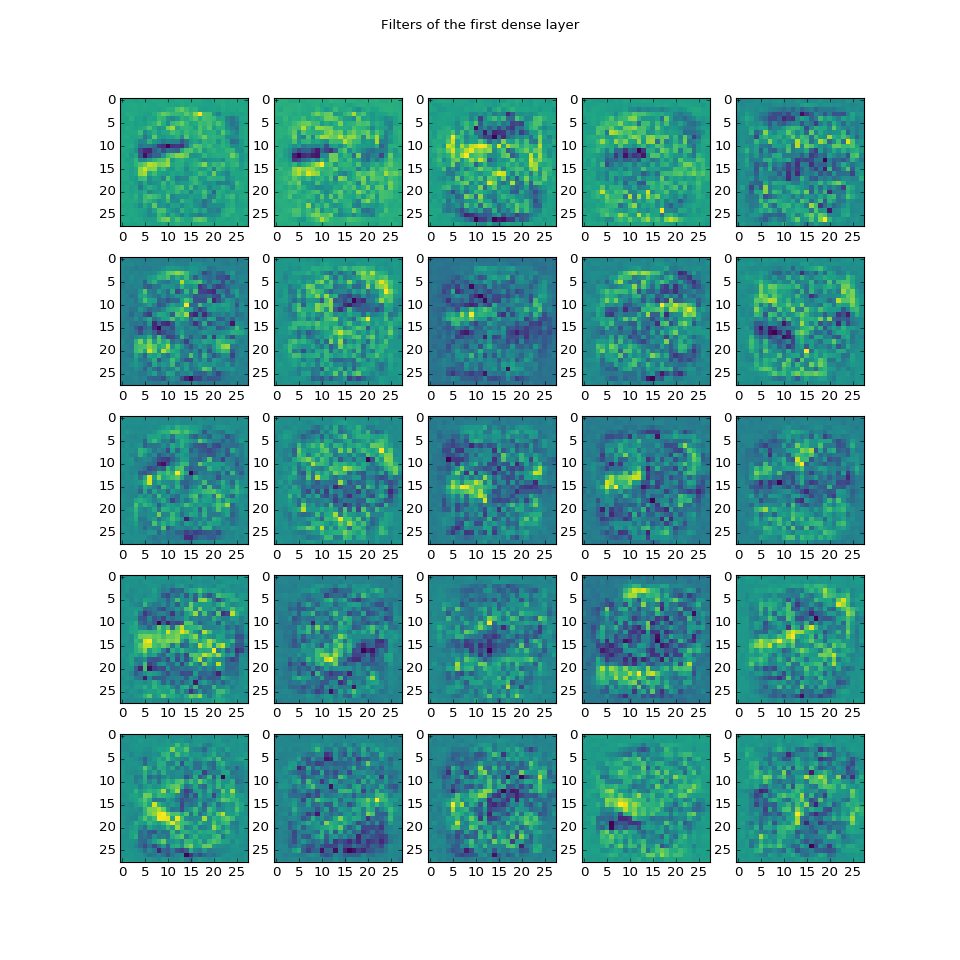

In [22]:
import itertools

n = 5
fig, ax = plt.subplots(n, n, figsize=(12, 12))

plt.suptitle('Filters of the first dense layer')

for i, j in itertools.product(range(n), range(n)):
    k = i * n + j
    ax[i, j].imshow(U.dot(V)[:, k].reshape(28, 28), interpolation='None', cmap=plt.cm.viridis)